# MGL870 - TP2 - Utilisation de l’apprentissage machine pour la détection des anomalies
## Pierre Joseph, Jonathan Mésidor, Mohamed Fehd Soufi
## Automne 2024


## Import required libraries

In [1]:
import os
import pandas as pd
import sys
sys.path.append('../../')
from logparser.Drain import LogParser
import re
import json
from collections import defaultdict
from tqdm import tqdm
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
import matplotlib.pyplot as plt
import seaborn as sns

## Preparation of the log files

### Split log file into train-valid-test (60-20-20)

In [2]:
import os

def split_logfile(input_file, train_file, valid_file, test_file, train_ratio=0.6, valid_ratio=0.2):
    """
    Splits a file into train, validation, and test sets based on the given ratios.

    Parameters:
    input_file (str): Path to the input file.
    train_file (str): Path to the output train file.
    valid_file (str): Path to the output validation file.
    test_file (str): Path to the output test file.
    train_ratio (float): Ratio of the train set size to the total size (default is 0.6).
    valid_ratio (float): Ratio of the validation set size to the total size (default is 0.2).
    """
    # Read the input file
    with open(input_file, 'r') as file:
        lines = file.readlines()

    # Calculate split indices
    train_split_index = int(len(lines) * train_ratio)
    valid_split_index = int(len(lines) * (train_ratio + valid_ratio))

    # Split the lines into train, validation, and test sets
    train_lines = lines[:train_split_index]
    valid_lines = lines[train_split_index:valid_split_index]
    test_lines = lines[valid_split_index:]

    # Write the train set to the train file
    with open(train_file, 'w') as file:
        file.writelines(train_lines)

    # Write the validation set to the validation file
    with open(valid_file, 'w') as file:
        file.writelines(valid_lines)

    # Write the test set to the test file
    with open(test_file, 'w') as file:
        file.writelines(test_lines)

    print(f"Split completed: \n {len(train_lines)} lines in {train_file} \n {len(valid_lines)} lines in {valid_file} \n {len(test_lines)} lines in {test_file}")


In [3]:
split_logfile(input_file='input/BGL/BGL.log', 
              train_file='input/BGL/BGL_train.log', 
              valid_file='input/BGL/BGL_valid.log', 
              test_file='input/BGL/BGL_test.log')

#Split completed: 
 #2848777 lines in input/BGL/BGL_train.log 
 #949593 lines in input/BGL/BGL_valid.log 
 #949593 lines in input/BGL/BGL_test.log

Split completed: 
 2848777 lines in input/BGL/BGL_train.log 
 949593 lines in input/BGL/BGL_valid.log 
 949593 lines in input/BGL/BGL_test.log


### Drain 3 parser on BGL_train.log, BGL_valid.log and BGL_test.log

In [4]:
# Configuration and setup for TemplateMiner
config = TemplateMinerConfig()
drain_parser = TemplateMiner(config=config)

# Define log pattern to match log fields
log_pattern = re.compile(
    r"(?P<Label>\S+)\s"               # Match the Label (e.g., "-")
    r"(?P<PId>\S+)\s"                 # Match the Process ID (e.g., "1117838570")
    r"(?P<Date>\d{4}\.\d{2}\.\d{2})\s"  # Match the Date (e.g., "2005.06.03")
    r"(?P<Node>\S+)\s"                # Match the Node (e.g., "R02-M1-N0-C:J12-U11")
    r"(?P<Timestamp>\S+)\s"           # Match the Timestamp (e.g., "2005-06-03-15.42.50.675872")
    r"(?P<NodeRepeat>\S+)\s"          # Match the repeated Node (e.g., "R02-M1-N0-C:J12-U11")
    r"(?P<Type>\S+)\s"                # Match the Type (e.g., "RAS")
    r"(?P<Component>\S+)\s"           # Match the Component (e.g., "KERNEL")
    r"(?P<Level>\S+)\s"               # Match the Level (e.g., "INFO")
    r"(?P<Content>.+)"                # Match the Content (e.g., "instruction cache parity error corrected")
)

In [5]:
# Train

with open('input/BGL/BGL_train.log', 'r') as log_file:
    for line in log_file:
        # Remove any leading/trailing whitespace from the line
        line = line.strip()
        match = log_pattern.match(line)
        if match:
            log_content = match.group("Content")  # Extract the Content field
            result = drain_parser.add_log_message(log_content)
            #On ne met pas le template maintenant, parce qu'à chaque ligne, il génère un arbre. Il faut faire dans deux boucles séparées
            
log_data = []

# Process the log file with a progress bar
with open('input/BGL/BGL_train.log', 'r') as log_file:
    previous_timestamp = None  # Initialize the previous timestamp for calculating DeltaT
    for line in tqdm(log_file, desc="Processing log file"):
        line = line.strip()  # Remove leading/trailing whitespace
        match = log_pattern.match(line)
        if match:
            # Extract matched fields
            log_content = match.group("Content")
            timestamp_str = match.group("Timestamp")
            label = 1 if match.group("Label") == '-' else 0  # Replace '-' with 1, others with 0
            
            # Convert Timestamp to Unix format
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%d-%H.%M.%S.%f').value // 10**9
            
            # Calculate DeltaT (difference in seconds from the previous log)
            deltaT = timestamp - previous_timestamp if previous_timestamp is not None else 0
            previous_timestamp = timestamp  # Update previous timestamp
            
            # Use Drain3 to match the log entry content
            result = drain_parser.match(log_content)

            # Create a dictionary with the parsed data
            log_entry = {
                "Timestamp": timestamp,
                "Content": log_content,
                "Matched Template": result.get_template() if result else "No Template",
                "Cluster ID": result.cluster_id if result else "No Cluster",
                "Label": label,
                "DeltaT": deltaT
            }
            
            # Append the dictionary to the list
            log_data.append(log_entry)

# Convert log data to DataFrame and save to CSV
df = pd.DataFrame(log_data)

# Save the parsed log data to a structured CSV
output_path = 'BGL_results/BGL_train_structured.csv'
df.to_csv(output_path, index=False)

print(f"Parsed log data saved to '{output_path}'")


Processing log file: 2848777it [03:05, 15357.80it/s]


Parsed log data saved to 'BGL_results/BGL_train_structured.csv'


In [6]:
# Valid

with open('input/BGL/BGL_valid.log', 'r') as log_file:
    for line in log_file:
        # Remove any leading/trailing whitespace from the line
        line = line.strip()
        match = log_pattern.match(line)
        if match:
            log_content = match.group("Content")  # Extract the Content field
            result = drain_parser.add_log_message(log_content)
            #On ne met pas le template maintenant, parce qu'à chaque ligne, il génère un arbre. Il faut faire dans deux boucles séparées

log_data = []

# Process the log file with a progress bar
with open('input/BGL/BGL_valid.log', 'r') as log_file:
    previous_timestamp = None  # Initialize the previous timestamp for calculating DeltaT
    for line in tqdm(log_file, desc="Processing log file"):
        line = line.strip()  # Remove leading/trailing whitespace
        match = log_pattern.match(line)
        if match:
            # Extract matched fields
            log_content = match.group("Content")
            timestamp_str = match.group("Timestamp")
            label = 1 if match.group("Label") == '-' else 0  # Replace '-' with 1, others with 0
            
            # Convert Timestamp to Unix format
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%d-%H.%M.%S.%f').value // 10**9
            
            # Calculate DeltaT (difference in seconds from the previous log)
            deltaT = timestamp - previous_timestamp if previous_timestamp is not None else 0
            previous_timestamp = timestamp  # Update previous timestamp
            
            # Use Drain3 to match the log entry content
            result = drain_parser.match(log_content)

            # Create a dictionary with the parsed data
            log_entry = {
                "Timestamp": timestamp,
                "Content": log_content,
                "Matched Template": result.get_template() if result else "No Template",
                "Cluster ID": result.cluster_id if result else "No Cluster",
                "Label": label,
                "DeltaT": deltaT
            }
            
            # Append the dictionary to the list
            log_data.append(log_entry)

# Convert log data to DataFrame and save to CSV
df = pd.DataFrame(log_data)

# Save the parsed log data to a structured CSV
output_path = 'BGL_results/BGL_valid_structured.csv'
df.to_csv(output_path, index=False)

print(f"Parsed log data saved to '{output_path}'")


Processing log file: 949593it [01:28, 10756.55it/s]


Parsed log data saved to 'BGL_results/BGL_valid_structured.csv'


In [7]:
# Test

with open('input/BGL/BGL_test.log', 'r') as log_file:
    for line in log_file:
        # Remove any leading/trailing whitespace from the line
        line = line.strip()
        match = log_pattern.match(line)
        if match:
            log_content = match.group("Content")  # Extract the Content field
            result = drain_parser.add_log_message(log_content)
            #On ne met pas le template maintenant, parce qu'à chaque ligne, il génère un arbre. Il faut faire dans deux boucles séparées

log_data = []

# Process the log file with a progress bar
with open('input/BGL/BGL_test.log', 'r') as log_file:
    previous_timestamp = None  # Initialize the previous timestamp for calculating DeltaT
    for line in tqdm(log_file, desc="Processing log file"):
        line = line.strip()  # Remove leading/trailing whitespace
        match = log_pattern.match(line)
        if match:
            # Extract matched fields
            log_content = match.group("Content")
            timestamp_str = match.group("Timestamp")
            label = 1 if match.group("Label") == '-' else 0  # Replace '-' with 1, others with 0
            
            # Convert Timestamp to Unix format
            timestamp = pd.to_datetime(timestamp_str, format='%Y-%m-%d-%H.%M.%S.%f').value // 10**9
            
            # Calculate DeltaT (difference in seconds from the previous log)
            deltaT = timestamp - previous_timestamp if previous_timestamp is not None else 0
            previous_timestamp = timestamp  # Update previous timestamp
            
            # Use Drain3 to match the log entry content
            result = drain_parser.match(log_content)

            # Create a dictionary with the parsed data
            log_entry = {
                "Timestamp": timestamp,
                "Content": log_content,
                "Matched Template": result.get_template() if result else "No Template",
                "Cluster ID": result.cluster_id if result else "No Cluster",
                "Label": label,
                "DeltaT": deltaT
            }
            
            # Append the dictionary to the list
            log_data.append(log_entry)

# Convert log data to DataFrame and save to CSV
df = pd.DataFrame(log_data)

# Save the parsed log data to a structured CSV
output_path = 'BGL_results/BGL_test_structured.csv'
df.to_csv(output_path, index=False)

print(f"Parsed log data saved to '{output_path}'")


Processing log file: 949593it [01:08, 13873.29it/s]


Parsed log data saved to 'BGL_results/BGL_test_structured.csv'


## Sliding Window

In [8]:
import pandas as pd
import numpy as np

def sliding_window(structured_log_path, para, output_path):
    """
    Split logs into sliding windows/session and aggregate by log keys with labels.
    
    :param structured_log_path: Path to the structured log file (CSV).
    :param para: Parameters for sliding window {"window_size": seconds, "step_size": seconds}.
    :param output_path: Path to save the resulting sliding window CSV.
    """
    # Read the structured log file
    df_structured = pd.read_csv(structured_log_path)  # Assumes columns: Timestamp, Content, Matched Template, Cluster ID, Label, DeltaT
    
    # Detect and handle different timestamp formats
    if df_structured['Timestamp'].dtype == 'int64' or df_structured['Timestamp'].str.isdigit().all():
        # If the timestamps are Unix timestamps, convert them directly
        df_structured['Timestamp'] = pd.to_datetime(df_structured['Timestamp'], unit='s')
    else:
        # Otherwise, assume the timestamps are in a formatted date string
        df_structured['Timestamp'] = pd.to_datetime(df_structured['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f', errors='coerce')
        if df_structured['Timestamp'].isnull().any():
            raise ValueError("Some timestamps could not be parsed. Please check the input file format.")

    # Parameters
    window_size = para["window_size"]  # Window size in seconds
    step_size = para["step_size"]      # Step size in seconds
    
    # Initialize results
    result = []
    start_time = df_structured['Timestamp'].min()
    end_time = start_time + pd.to_timedelta(window_size, unit='s')
    
    while start_time <= df_structured['Timestamp'].max():
        # Filter logs within the current window
        window_logs = df_structured[(df_structured['Timestamp'] >= start_time) & (df_structured['Timestamp'] < end_time)]
        
        if not window_logs.empty:
            # Count log keys (Cluster ID)
            log_key_counts = window_logs['Cluster ID'].value_counts().to_dict()
            
            # Aggregate anomaly labels (1 if any anomaly exists in the window, else 0)
            anomaly_label = int(window_logs['Label'].max())
            
            # Create a row with timestamp, log key counts, and anomaly label
            row = {
                'Timestamp': start_time,
                **{str(f"E{key}"): log_key_counts.get(key, 0) for key in range(1, len(df_structured['Cluster ID'].unique()) + 1)},
                'Anomaly': 'Fail' if anomaly_label == 1 else 'Success'
            }
            result.append(row)
        
        # Slide the window
        start_time += pd.to_timedelta(step_size, unit='s')
        end_time = start_time + pd.to_timedelta(window_size, unit='s')
    
    # Convert result to DataFrame and fill missing log keys with 0
    result_df = pd.DataFrame(result).fillna(0)
    
    # Save the result to CSV
    result_df.to_csv(output_path, index=False)
    print(f"Sliding window results saved to '{output_path}'")
# Parameters for sliding window (5-minute window with 30-second step)
window_size = 5 * 60  # 5 minutes in seconds
step_size = 30  # 30 seconds in seconds

In [9]:
# Train
sliding_window(
    structured_log_path="BGL_results/BGL_train_structured.csv",
    para={'window_size': window_size, 'step_size': step_size},
    output_path="BGL_results/BGL_train_sliding_window.csv"
)

Sliding window results saved to 'BGL_results/BGL_train_sliding_window.csv'


In [10]:
# Valid
sliding_window(
    structured_log_path="BGL_results/BGL_valid_structured.csv",
    para={'window_size': window_size, 'step_size': step_size},
    output_path="BGL_results/BGL_valid_sliding_window.csv"
)

Sliding window results saved to 'BGL_results/BGL_valid_sliding_window.csv'


In [11]:
# Test
sliding_window(
    structured_log_path="BGL_results/BGL_test_structured.csv",
    para={'window_size': window_size, 'step_size': step_size},
    output_path="BGL_results/BGL_test_sliding_window.csv"
)

Sliding window results saved to 'BGL_results/BGL_test_sliding_window.csv'


## Statistics


Processing file: BGL_results/BGL_train_structured.csv
Total logs: 2848240
Total failures: 2616361
Failure percentage: 91.86%

Failures by Cluster ID:
Cluster ID
3      1647987
11      226095
299     184248
1        66479
195      57781
        ...   
280          1
281          1
282          1
283          1
507          1
Name: count, Length: 485, dtype: int64


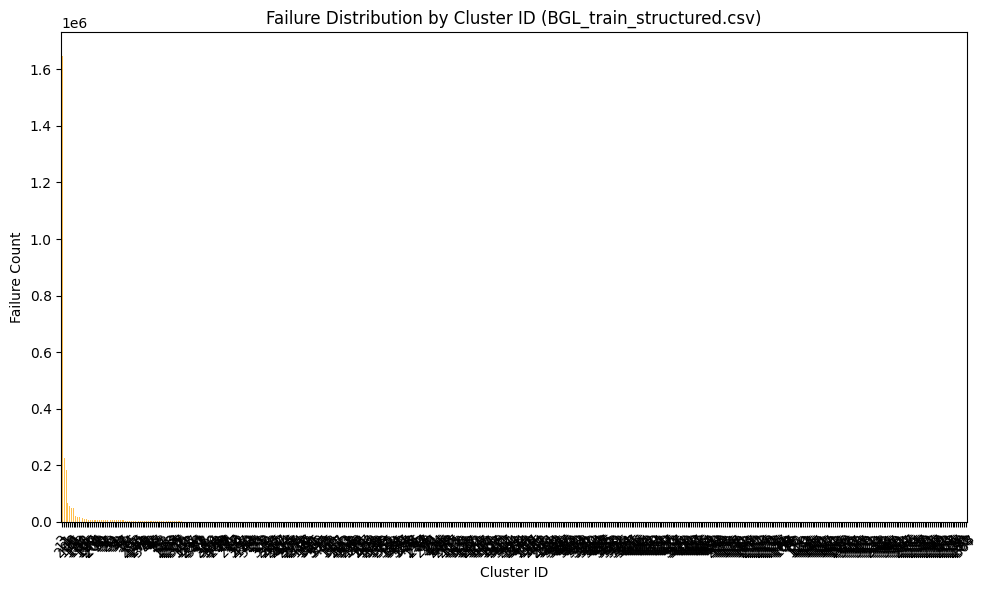


Failures over time:
Date
2005-06-03     14733
2005-06-04       693
2005-06-05    100811
2005-06-06     39457
2005-06-07     31919
2005-06-08     10526
2005-06-09     20279
2005-06-10      1460
2005-06-11       486
2005-06-12      3420
2005-06-13     19653
2005-06-14    332407
2005-06-15     14795
2005-06-16     22547
2005-06-17      4069
2005-06-18      5298
2005-06-19      3357
2005-06-20     22841
2005-06-21     12000
2005-06-22     20998
2005-06-23     19400
2005-06-24      3817
2005-06-25     95881
2005-06-26     65197
2005-06-27      7050
2005-06-28      8430
2005-06-29     54650
2005-06-30     79605
2005-07-01    142940
2005-07-02      9103
2005-07-03     53950
2005-07-04     61202
2005-07-05      1468
2005-07-06      3280
2005-07-07     62748
2005-07-08      1992
2005-07-09    380718
2005-07-10     33509
2005-07-11      3034
2005-07-12     26915
2005-07-13    198987
2005-07-14      7002
2005-07-15     80545
2005-07-16      1668
2005-07-17     66004
2005-07-18     30790
2005-07-

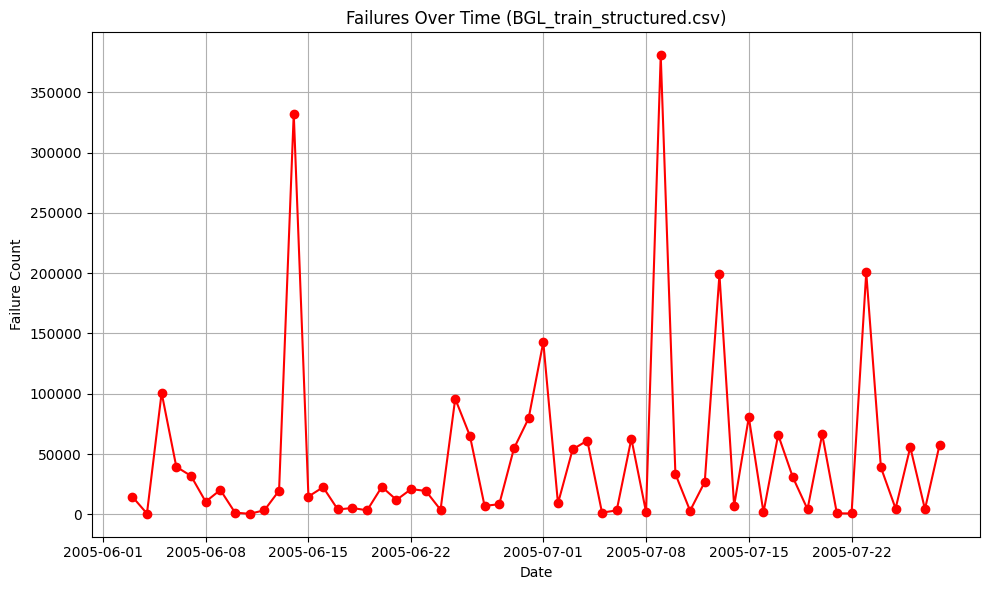


Statistics of time between failures (seconds):
count    2.616360e+06
mean     1.811529e+00
std      1.034910e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.143300e+04
Name: Timestamp, dtype: float64


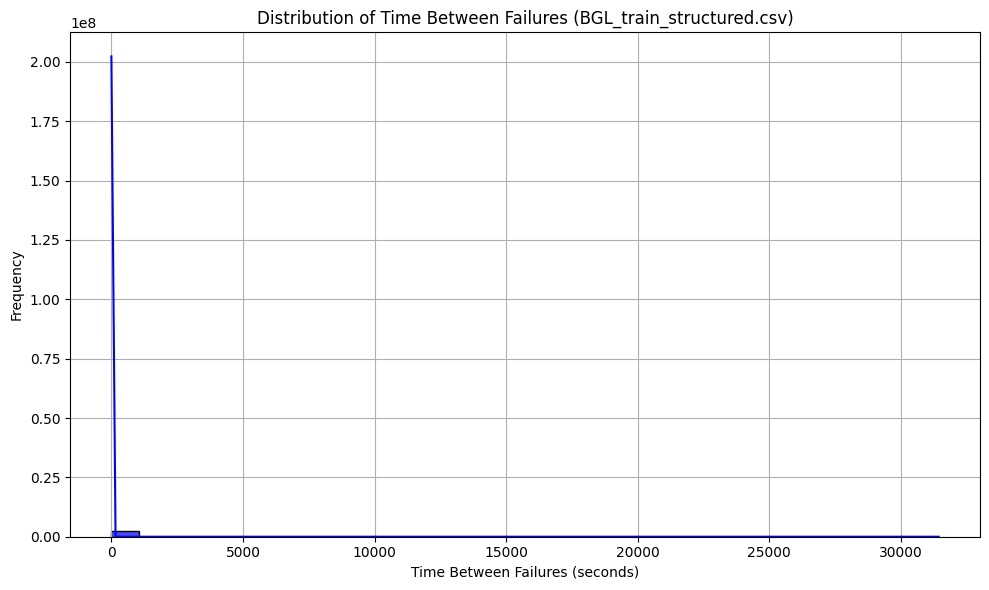


Processing file: BGL_results/BGL_valid_structured.csv
Total logs: 945057
Total failures: 874759
Failure percentage: 92.56%

Failures by Cluster ID:
Cluster ID
582    185159
6      102006
527     84168
11      69669
3       58764
        ...  
734         1
733         1
732         1
731         1
672         1
Name: count, Length: 633, dtype: int64


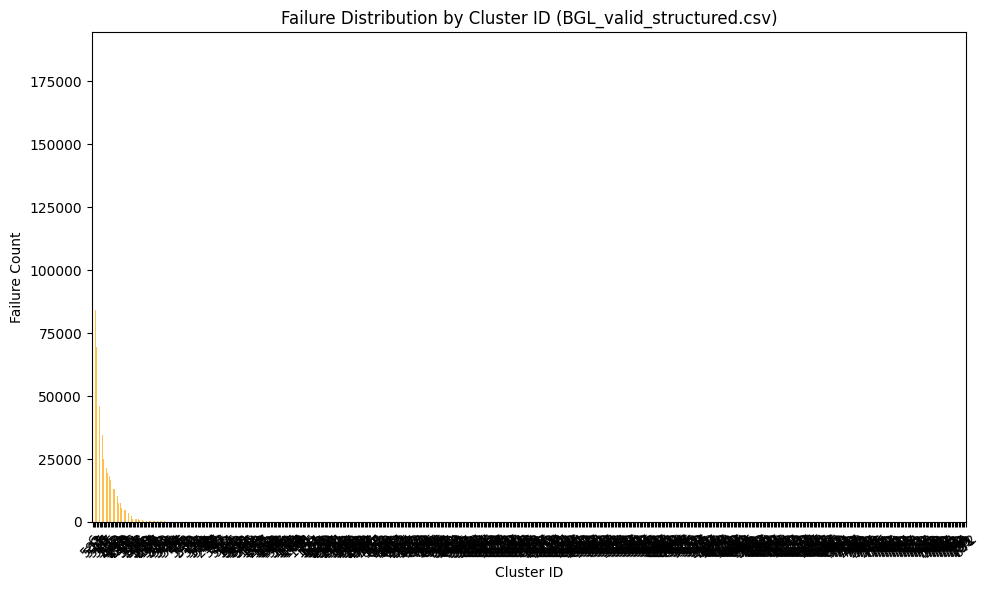


Failures over time:
Date
2005-07-28     59057
2005-07-29       786
2005-07-30        79
2005-07-31        96
2005-08-02     21049
               ...  
2005-10-30      6842
2005-10-31      9162
2005-11-01      4338
2005-11-02      2455
2005-11-03    105050
Length: 98, dtype: int64


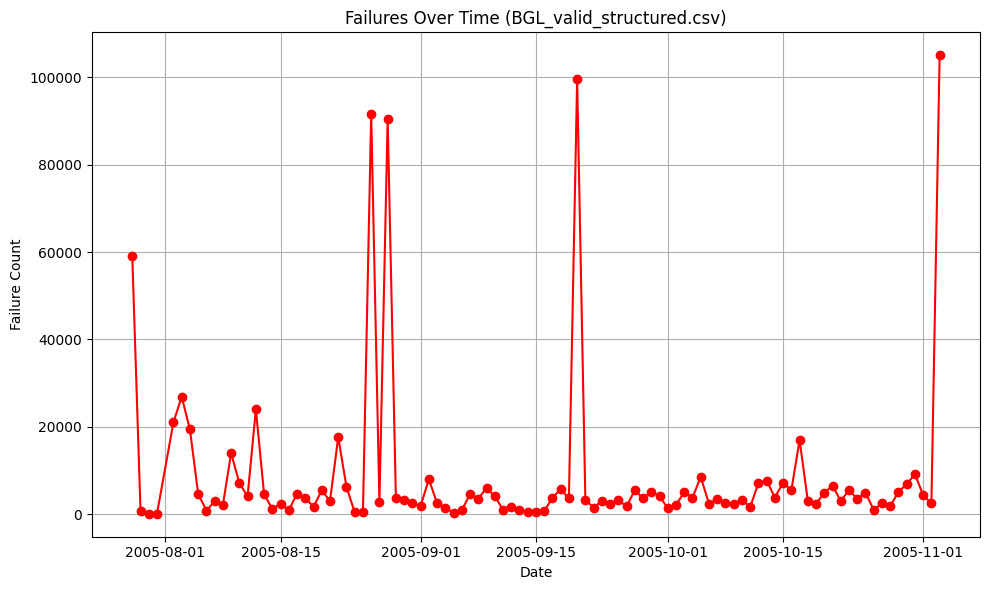


Statistics of time between failures (seconds):
count    874758.000000
mean          9.692347
std         347.492971
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      176572.000000
Name: Timestamp, dtype: float64


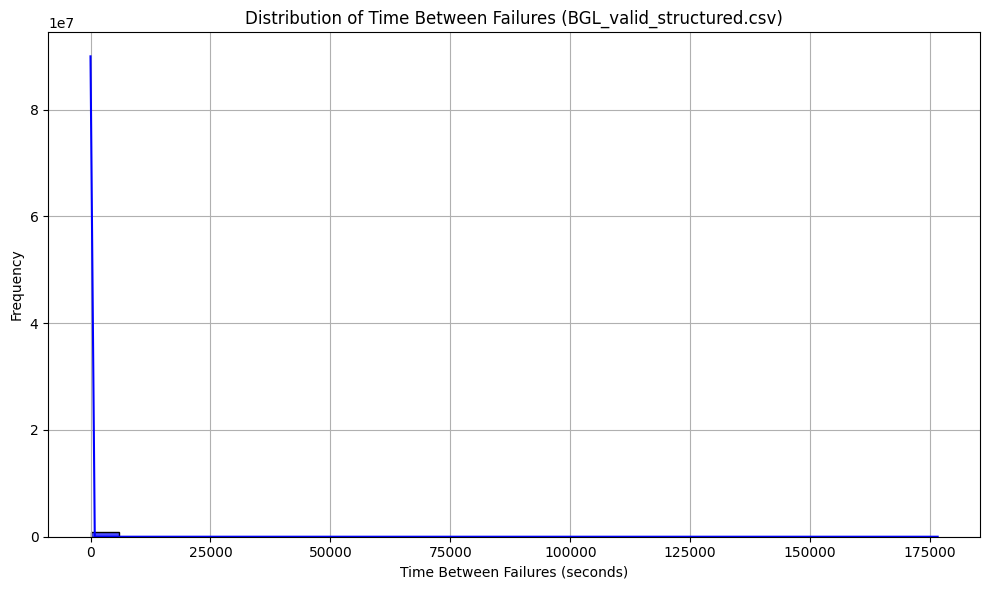


Processing file: BGL_results/BGL_test_structured.csv
Total logs: 920196
Total failures: 873913
Failure percentage: 94.97%

Failures by Cluster ID:
Cluster ID
582     257807
1406    135092
1407    135092
299      66709
6        49077
         ...  
1357         1
1358         1
1359         1
1360         1
1822         1
Name: count, Length: 1013, dtype: int64


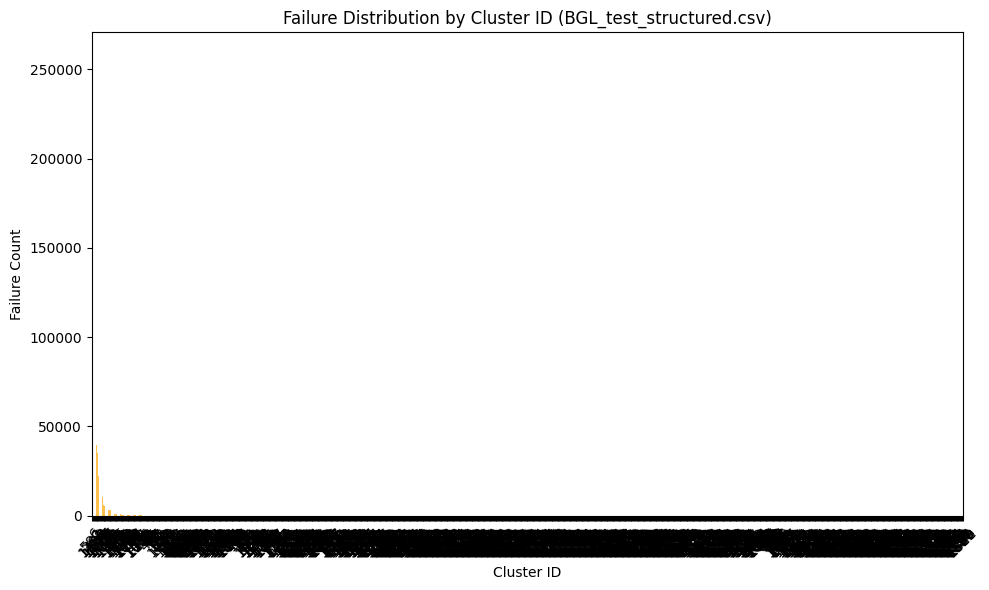


Failures over time:
Date
2005-11-03     91137
2005-11-04    136039
2005-11-05      4207
2005-11-06       594
2005-11-07     22668
               ...  
2005-12-31       381
2006-01-01       566
2006-01-02       854
2006-01-03       998
2006-01-04        78
Length: 63, dtype: int64


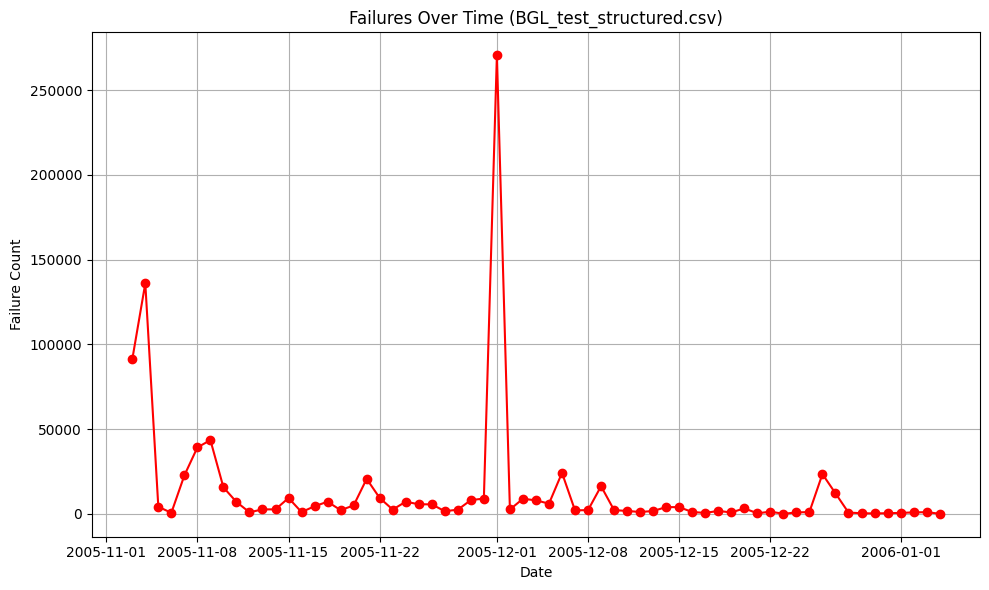


Statistics of time between failures (seconds):
count    873912.000000
mean          6.098726
std         230.956353
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       64177.000000
Name: Timestamp, dtype: float64


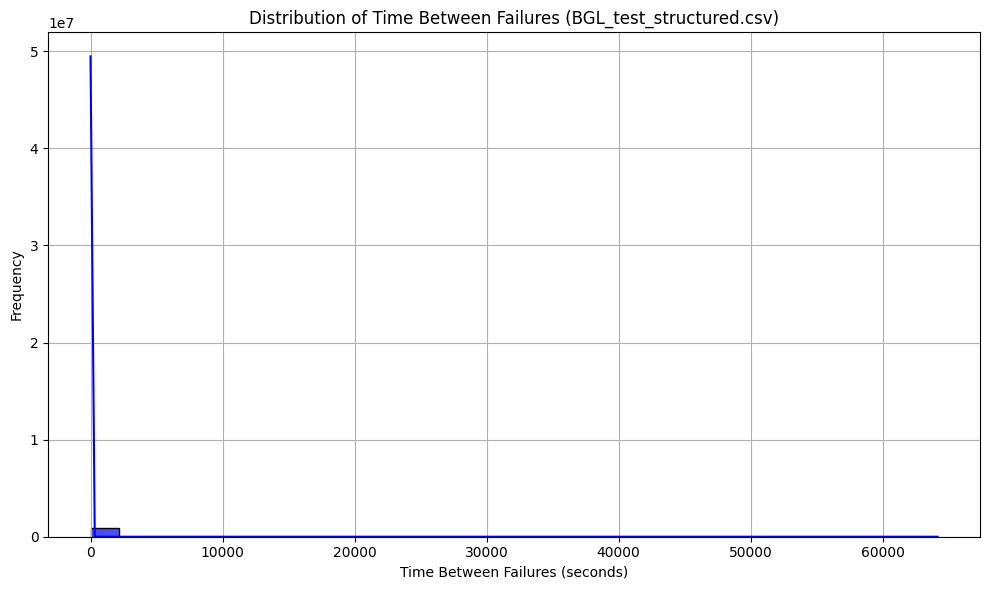

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the directory and file names
log_files = [
    "BGL_results/BGL_train_structured.csv",
    "BGL_results/BGL_valid_structured.csv",
    "BGL_results/BGL_test_structured.csv"
]

# Iterate through the log files
for log_file in log_files:
    if not os.path.exists(log_file):
        print(f"File not found: {log_file}")
        continue
    
    print(f"\nProcessing file: {log_file}")
    
    # Load the structured log data
    df = pd.read_csv(log_file)
    
    # Convert Timestamp to datetime for easier handling
    try:
        if df['Timestamp'].dtype in ['int64', 'float64']:
            # If the Timestamp is in Unix format
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
        else:
            # If the Timestamp is a string, attempt to parse it
            df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%Y-%m-%d-%H.%M.%S.%f', errors='coerce')
        
        # Check for unparsed Timestamps
        if df['Timestamp'].isna().any():
            raise ValueError("Some timestamps could not be parsed. Check the format of your input data.")
    except Exception as e:
        print(f"Error processing Timestamps in file {log_file}: {e}")
        continue
    
    # Replace Label with numeric values (1 for Anomaly, 0 for Normal)
    df['Label'] = df['Label'].apply(lambda x: 1 if x == 1 else 0)
    
    # Total logs and failures
    total_logs = len(df)
    total_failures = df['Label'].sum()
    failure_percentage = (total_failures / total_logs) * 100
    
    print(f"Total logs: {total_logs}")
    print(f"Total failures: {total_failures}")
    print(f"Failure percentage: {failure_percentage:.2f}%")
    
    # Failure distribution by Cluster ID (log key)
    failure_by_cluster = df[df['Label'] == 1]['Cluster ID'].value_counts()
    print("\nFailures by Cluster ID:")
    print(failure_by_cluster)
    
    # Plot: Failure distribution by Cluster ID
    plt.figure(figsize=(10, 6))
    failure_by_cluster.plot(kind='bar', color='orange', alpha=0.7)
    plt.title(f'Failure Distribution by Cluster ID ({os.path.basename(log_file)})')
    plt.xlabel('Cluster ID')
    plt.ylabel('Failure Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Failure distribution over time
    df['Date'] = df['Timestamp'].dt.date
    failures_over_time = df[df['Label'] == 1].groupby('Date').size()
    
    print("\nFailures over time:")
    print(failures_over_time)
    
    # Plot: Failures over time
    plt.figure(figsize=(10, 6))
    failures_over_time.plot(kind='line', marker='o', color='red')
    plt.title(f'Failures Over Time ({os.path.basename(log_file)})')
    plt.xlabel('Date')
    plt.ylabel('Failure Count')
    plt.grid()
    plt.tight_layout()
    plt.show()
    
    # Duration between failures
    failure_timestamps = df[df['Label'] == 1]['Timestamp']
    failure_deltas = failure_timestamps.diff().dt.total_seconds().dropna()
    print("\nStatistics of time between failures (seconds):")
    print(failure_deltas.describe())
    
    # Plot: Distribution of time between failures
    plt.figure(figsize=(10, 6))
    sns.histplot(failure_deltas, kde=True, bins=30, color='blue', alpha=0.7)
    plt.title(f'Distribution of Time Between Failures ({os.path.basename(log_file)})')
    plt.xlabel('Time Between Failures (seconds)')
    plt.ylabel('Frequency')
    plt.grid()
    plt.tight_layout()
    plt.show()
